In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
with ZipFile("archive.zip","r") as zip:
    zip.extractall()

In [4]:
batch_size = 32
img_size = (224,224)

train_ds = image_dataset_from_directory(
    "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    shuffle = True,
    image_size = img_size,
    batch_size = batch_size,
)

val_ds = image_dataset_from_directory(
    "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    shuffle = True,
    image_size = img_size,
    batch_size = batch_size,
)

Found 4200 files belonging to 2 classes.
Using 3360 files for training.
Found 4200 files belonging to 2 classes.
Using 840 files for validation.


['Normal', 'Tuberculosis']


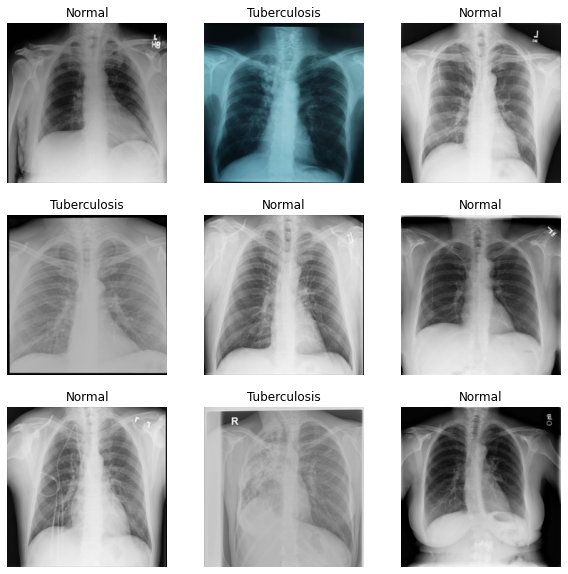

In [5]:
from tensorflow.data.experimental import cardinality

val_batches = cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom

data_augmentation = Sequential([
    RandomZoom(0.2),
])

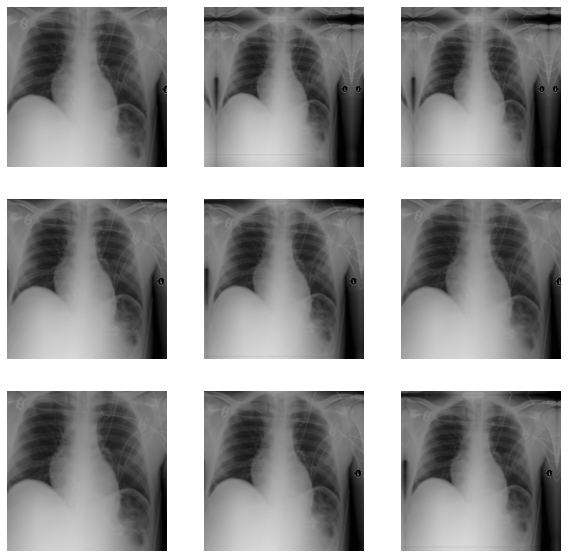

In [8]:
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Building the model

In [9]:
from tensorflow.keras.applications import vgg19
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Input, Model

preprocess_input = vgg19.preprocess_input

IMG_SHAPE = img_size+(3,)
base_model = VGG19(input_shape=IMG_SHAPE,include_top=False,weights="imagenet")
image_batch,label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()
feature_batch_average = GlobalAveragePooling2D()(feature_batch)

prediction_layer = Dense(2,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)

class Transfer_Vgg19():
    def model(self,y):
        self.x = data_augmentation(y)
        self.x = preprocess_input(self.x)
        self.x = base_model(self.x,training=False)
        self.x = GlobalAveragePooling2D()(self.x)
        self.x = Dropout(0.2,seed=42)(self.x)
        self.outputs = prediction_layer(self.x)
        self.model = Model(y,self.outputs)
        return self.model

m = Transfer_Vgg19()
model = m.model(Input(shape=IMG_SHAPE))
model.summary()
model.compile(Adam(),SparseCategoricalCrossentropy(),metrics=["accuracy"])

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Train and test the model on test dataset

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

if __name__=="__main__":
    loss0,accuracy0 = model.evaluate(val_ds)
    print("Initial loss: {:.2f} %".format(100*loss0))
    print("Initial accuracy: {:.2f} %".format(100*accuracy0))
    checkpoint = ModelCheckpoint("tuberculosis.hdf5",save_weights_only=False,monitor="val_loss",save_best_only=True)
    model.fit(train_ds,epochs=6,validation_data=val_ds,callbacks=[checkpoint])
    best = load_model("tuberculosis.hdf5")
    loss,accuracy = best.evaluate(test_ds)
    print("\nTest accuracy: {:.2f} %".format(100*accuracy))
    print("Test loss: {:.2f} %".format(100*loss))

22/22 [==============================] - 17s 421ms/step - loss: 2.5185 - accuracy: 0.2618
Initial loss: 251.85 %
Initial accuracy: 26.18 %
Epoch 1/6
105/105 [==============================] - 39s 364ms/step - loss: 0.6389 - accuracy: 0.8438 - val_loss: 0.1610 - val_accuracy: 0.9471
Epoch 2/6
105/105 [==============================] - 39s 369ms/step - loss: 0.2245 - accuracy: 0.9238 - val_loss: 0.0718 - val_accuracy: 0.9721
Epoch 3/6
105/105 [==============================] - 39s 368ms/step - loss: 0.1681 - accuracy: 0.9446 - val_loss: 0.0513 - val_accuracy: 0.9824
Epoch 4/6
105/105 [==============================] - 39s 373ms/step - loss: 0.1313 - accuracy: 0.9563 - val_loss: 0.0312 - val_accuracy: 0.9897
Epoch 5/6
105/105 [==============================] - 40s 375ms/step - loss: 0.1158 - accuracy: 0.9610 - val_loss: 0.0393 - val_accuracy: 0.9838
Epoch 6/6
5/5 [==============================] - 2s 302ms/step - loss: 0.0755 - accuracy: 0.9750

Test accuracy: 97.50 %
Test loss: 7.55 %
